In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.linear_model import LinearRegression, Lasso # Logistic Regression Model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #model evaluation
from pathlib import Path 


from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans # k-means
from sklearn.mixture import GaussianMixture # EM/GMM
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture


%matplotlib inline

# Next Questions

In this part of the project, we will be analyzing new data sets from Garmin watches. I have had the watch since July and have gone on about 35 runs; therefore, there are not enought data points to analyze only my running. However, I use the watch to track all of my other workouts. The first dataset tracks all of my activities statistics. For the next data set, we will be analyzing many health statistics. Since I wear my watch almost 24/7 for the last 6 months, it has tracked many various health statistics.

# Activities Dataset
The activities dataset consists of statistics for each activitiy/exercise/workout that I have recorded. These include but are not limited to running, strength training, cycling, hiking, and cardio. I did not exercise every single day so the number of datapoints is not equal to the number of days that I have had my watch. Each specific type of activity can record statstics that don't apply to certain other activities - such as measuring distance when I am doing strength training. The full list of statistics that can be measured for any of the activities are here <sup>1</sup>. I will use the variables that apply to every activity: 

- `Activity Type`: What kind of activity/exercise it was
- `Date`:  Year month and Day of the activity
- `Time`: Duration of the activity
- `Calories`: Calories burned
- `Avg HR`: Average heart rate
- `Max HR`: Max heart rate

<sup>1</sup>('Activity Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories',
       'Time', 'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence',
       'Max Run Cadence', 'Avg Speed', 'Max Speed', 'Elev Gain', 'Elev Loss',
       'Avg Stride Length', 'Avg Vertical Ratio', 'Avg Vertical Oscillation',
       'Training Stress Score®', 'Grit', 'Flow', 'Total Reps', 'Total Sets',
       'Climb Time', 'Bottom Time', 'Min Temp', 'Surface Interval',
       'Decompression', 'Best Lap Time', 'Number of Laps', 'Max Temp',
       'Avg Resp', 'Min Resp', 'Max Resp')

In [46]:
activities = pd.read_csv("michael_new_activities.csv")
activities.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Best Lap Time,Number of Laps,Max Temp,Avg Resp,Min Resp,Max Resp,Stress Change,Stress Start,Stress End,Avg Stress
0,Cycling,2020-12-06,False,San Jose Cycling,25.35,890,1:49:24,123,166,2.8,...,03:15.0,6,0,16,16,16,--,--,--,--
1,Cycling,2020-12-05,False,San Jose Cycling,33.46,"1,303",2:00:28,138,178,3.4,...,12:30.1,7,0,17,17,17,--,--,--,--
2,Strength Training,2020-12-04,False,Strength,0.00,252,0:32:57,113,139,1.2,...,32:57.3,1,0,18,18,18,--,--,--,--
3,Cycling,2020-12-04,False,San Jose Cycling,11.80,639,0:51:33,140,178,3.1,...,07:35.9,3,0,16,16,16,--,--,--,--
4,Cycling,2020-12-03,False,San Jose Cycling,20.51,906,1:17:08,140,179,3.1,...,02:08.1,5,0,16,16,16,--,--,--,--


Number of activities: 191


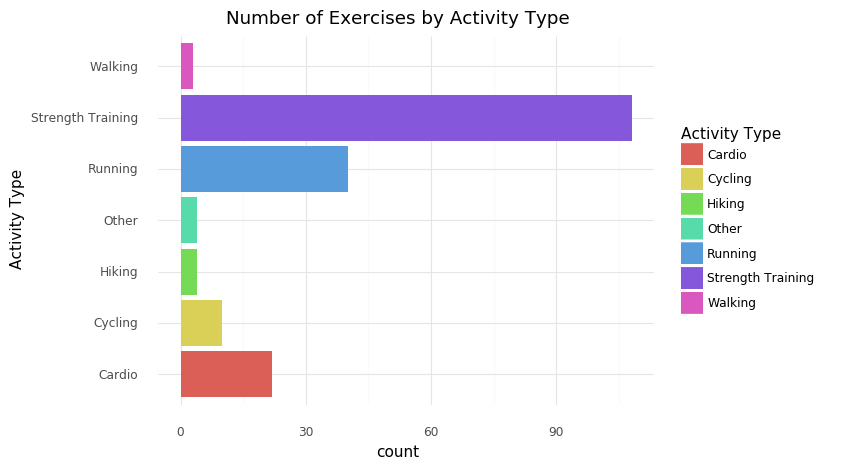

<ggplot: (8782352046681)>

In [47]:
# total number of workouts over 152 days
print("Number of activities:",len(activities))
# The distribution of the types of my workouts
(ggplot(activities, aes(x = "Activity Type", fill = "Activity Type")) 
 + geom_bar()
 + coord_flip()
 + theme_minimal()
 + labs(title='Number of Exercises by Activity Type'))

Above is the distribution of my exercises. I have a total of 191 different activities over the course of 152 days because I worked out multiple times in a day numerous times. However, there are still many days in which I did not work out.

# Health Statistics Dataset
The health stats dataset consists of a datapoint for every day since I started wearing the watch. The variables for each datapoint are:

- `Date`: Day and month
- `Day`: Day of the week
- `Stress Level`: Overall stress level for the day using a metric called heart rate variability(HRV) <sup>2</sup>
- `Sleep Hours`: Hours of sleep
- `Resting Heart Rate`: Resting heart rate <sup>3</sup>
- `Max Heart Rate`: Highest heart rate for the day
- `Active Calories`: Calories Burned in Motion <sup>4</sup>
- `Total Steps`: Number of steps taken

<sup>2</sup> When using the stress level feature, the device uses heart rate data to determine the interval between each heart beat. The variable length of time in between each heart beat is regulated by the body's autonomic nervous system. The less variability between beats equals higher stress levels, whereas the increase in variability indicates less stress. [Stress level feature](https://support.garmin.com/en-US/?faq=WT9BmhjacO4ZpxbCc0EKn9) [HRV](https://support.garmin.com/en-US/?faq=04pnPSBTYSAYL9FylZoUl5)

<sup>3</sup> Resting heart rate can be a key indicator of your heart's health. The Garmin device analyzes your lowest observed heart rate for a given day to determine your ersting heart rate. The main things that can affect heart rate are Exercise, Stress, Caffeine, Medication, Illness

<sup>4</sup> Active calories are the calories that you burn while moving throguhout the day.

In [48]:
health = pd.read_csv("michael_data.csv")
health.head()

,Date,Day,Stress Level,Sleep Hours,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps
0,8-Jul,Wed,20,8.7,42,158,1753,21366
1,9-Jul,Thu,31,8.5,46,182,1098,15775
2,10-Jul,Fri,32,7.6,49,165,1026,12190
3,11-Jul,Sat,32,6.1,46,143,993,20126
4,12-Jul,Sun,32,4.1,47,129,1054,20092


# Questions
Using these two datasets, I want to answer these questions:
### 1) Is stress level higher on days when you don’t exercise compared to if you do exercise?
### 2) What has the largest effect on stress, what is the best way to reduce stress, and how well can you predict stress from the other variables in the dataset?
### 3) How can the activities be clustered and what are the characteristics of each cluster?

* I changed question 3 from my analysis plan.

# Data pre-processing

## Clean up Activities

In [49]:
# Change the data from 'year-month-day' to 'day-month' in order to match the health dataset syntax 
def change_date(dates):
    month_dict = {"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05": "May", "06": "Jun", "07": "Jul", "08": "Aug", "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"}
    new_dates = []
    for row in dates:
        date_str = row.split()[0]
        month = month_dict[date_str.split("-")[1]]
        day = date_str.split("-")[2]
        if int(day) < 10:
            day = day[1]
        new_dates.append(day + "-" +  month)
    return new_dates

# convert the column of Time from "Hours:Minutes:Seconds" to "minutes" for each Time
def change_time(times): # List of times
    conversion = [60, 1, 1/60]
    new_times = []
    for row in times:
        time_list = row.split(":")
        minutes = 0.

        # multiple the respective indeces "Hours:Minutes:Seconds" by specific
        # amount to convert to minutes
        for i, conv in zip(time_list, conversion): 
            minutes += float(i) * conv

        new_times.append(round(minutes, 3))
    return new_times

# convert the column of calories for string values to int for each calorie
def calories_to_num(calories):
    return [int(calorie.replace(",", "")) for calorie in calories]

# keep only the columns that we need
def delete_columns(df):
    return df[["Activity Type", "Date", "Time", "Calories", "Avg HR", "Max HR"]]

In [50]:
activities = pd.read_csv("michael_new_activities.csv")
activities["Date"] = change_date(activities["Date"])
activities["Time"] = change_time(activities["Time"])
activities["Calories"] = calories_to_num(activities["Calories"])
activities = delete_columns(activities)
activities.head()

,Activity Type,Date,Time,Calories,Avg HR,Max HR
0,Cycling,6-Dec,109.400,890,123,166
1,Cycling,5-Dec,120.467,1303,138,178
2,Strength Training,4-Dec,32.950,252,113,139
3,Cycling,4-Dec,51.550,639,140,178
4,Cycling,3-Dec,77.133,906,140,179


## Fix the health dataset

In [51]:
# reverse the order of the dataset so that the most recent days 
# are at the top and the oldest days are at the bottome
def reverse_data(df):
    cols = df.columns.tolist()
    for i in cols:
        col = df[i].tolist()
        col.reverse()
        health[i] = col
    return df

# add a column for the number of days since wearing the watch
def append_days_num(df):
    days = [i for i in range(len(df),0,-1)]
    df["Day Num"] = days
    return df

# add a column to differentiate if the day was a week day or weekend
def append_weekends(df): 
    weekend = ["Fri", "Sat", "Sun" ]
    weekendData = ["Week Day"] * len(df)
    for i in range(len(df)):
        if (health["Day"][i] in weekend):
            weekendData[i] = "Weekend"
    df["Days of the Week"] = weekendData
    return df

In [52]:
health = pd.read_csv("michael_data.csv")
health = reverse_data(health)
health = append_days_num(health)
health = append_weekends(health)
health.head()

,Date,Day,Stress Level,Sleep Hours,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps,Day Num,Days of the Week
0,6-Dec,Sun,22,8.1,43,159,1062,8070,152,Weekend
1,5-Dec,Sat,29,8.5,45,169,1703,9244,151,Weekend
2,4-Dec,Fri,21,8.2,44,165,997,7791,150,Weekend
3,3-Dec,Thu,17,7.9,43,165,932,4402,149,Week Day
4,2-Dec,Wed,27,6.7,45,159,760,6286,148,Week Day


## Add Exercise Info Into Health Dataset
Now in order to answer the questions and compare my health statistics on days that I do exercise vs don't, I will need to add a column into the health dataset telling me if I exercised that day or not

In [53]:
# iterage through the days and look into the activities dataset to see if I exercised. I will add two columns
# The first will be a binary numerical column so that I can use this for Logistic Regression
# the second column is a binary string column used for graphs
def exercise_per_day(df_health, df_activities):
    date_health = df_health["Date"].tolist()
    date_exercise = df_activities["Date"].tolist()
    df_combined = df_health
    exercise = [0] * len(date_health)
    exercise_str = ["No Exercise"] * len(date_health)

    for i in range(len(date_health)): #len(date_health)):
        if date_health[i] in date_exercise:
            exercise[i] = 1
            exercise_str[i] = "Yes Exercise"
    df_combined["Exercise"] = exercise
    df_combined["Exercise_word"] = exercise_str
    return df_combined

## Clean Up Combined Dataset
I will be removing days where I did not wear the watch while sleeping because those days will give inaccurate health stats. Also I will be removing the days were my `Stress Level` was below 14 because on those days, I did not wear my watch for several hours during the day, and that level is very low and not conclusive. Overall, both of these changes take out the days where I did not wear my watch the full day.

In [54]:
df_combined = exercise_per_day(health, activities)
print("Number of days in dataset before Clean:", len(df_combined))
df_combined = df_combined.loc[df_combined["Sleep Hours"] != 0]
df_combined = df_combined.loc[df_combined["Stress Level"] > 14]
print("Number of days in dataset after Clean:", len(df_combined))
print()
print("Number of days I didn't workout:",df_combined["Exercise"].tolist().count(0))
print("Number of days I did workout:", df_combined["Exercise"].tolist().count(1))
df_combined.head()

Number of days in dataset before Clean: 152
Number of days in dataset after Clean: 123

Number of days I didn't workout: 29
Number of days I did workout: 94


,Date,Day,Stress Level,Sleep Hours,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps,Day Num,Days of the Week,Exercise,Exercise_word
0,6-Dec,Sun,22,8.1,43,159,1062,8070,152,Weekend,1,Yes Exercise
1,5-Dec,Sat,29,8.5,45,169,1703,9244,151,Weekend,1,Yes Exercise
2,4-Dec,Fri,21,8.2,44,165,997,7791,150,Weekend,1,Yes Exercise
3,3-Dec,Thu,17,7.9,43,165,932,4402,149,Week Day,1,Yes Exercise
4,2-Dec,Wed,27,6.7,45,159,760,6286,148,Week Day,1,Yes Exercise


As seen above, my new data set constists of 123 days, 29 of which I did not exercise and 94 of which that I did exercise. 

Now we have everything we need to answer the first question:


# Answering The Questions

## Question 1: Is stress level higher on days when you don’t exercise compared to if you do exercise?

For this, we will be answering the question if exercise really does reduce stress. 

Mean Stress Level if I exercised: 24.414893617021278
Mean Stress Level if I didn't exercise 32.241379310344826


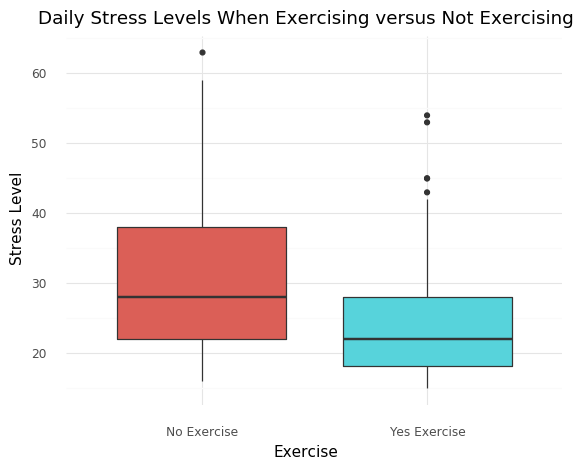

<ggplot: (8782358982581)>

In [55]:
print("Mean Stress Level if I exercised:",df_combined["Stress Level"].loc[df_combined["Exercise"] == 1].mean())
print("Mean Stress Level if I didn't exercise",df_combined["Stress Level"].loc[df_combined["Exercise"] == 0].mean())

(ggplot(df_combined, aes(x = "Exercise_word", y = "Stress Level", fill = "Exercise_word"))
 + geom_boxplot()
 + theme_minimal()
 + theme(legend_position = "none")
 + labs(x = "Exercise", title = "Daily Stress Levels When Exercising versus Not Exercising"))

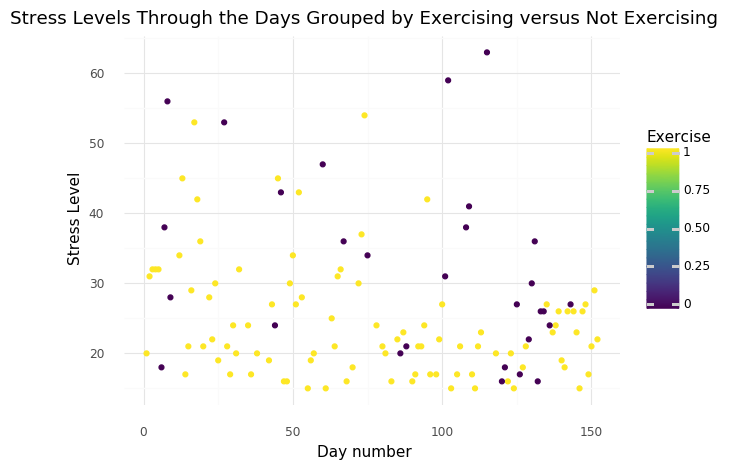

<ggplot: (8782351815721)>

In [73]:
(ggplot(df_combined, aes(x = "Day Num", y = "Stress Level", color = "Exercise"))
 + geom_point()
 + theme_minimal()
 + labs(x = "Day number", title = "Stress Levels Through the Days Grouped by Exercising versus Not Exercising"))

Day number 1 represents the first day I started wearing my watch. When I exercise, the points are yellow and are much lower on average than the purple points. My stress levels have been consolidating to be more consistent over the last several months.

## Question 1 Conclusion
My stress level for the days that I did exercise was 24.41, and my stress level for the days that I didn't exercise was 32.24. There is a staggering 24% decrease in my stress levels because of exercise. For reference, levels between 0-25 are considered to be a state a rest and relaxation. Levels between 26-50 are considered to be low stress. These values in my dataset are calculated by my average stress level throughout the day (24 hours). 
Therefore, it is clear that exercise does decrease stress and is a also a great way to reduce stress. I always hear people recommend to workout everyday in order to reduce stress and anxiety, but until now I never had evidence that exercise does actually reduce stress. So to me, these results are really fascinating and are a great motivation for me to keep exercising every day.

## Question 2: What has the largest effect on stress, what is the best way to reduce stress, and how well can you predict stress from the other variables in the dataset.

For this question, I will look at how sleep, resting heart rate, active calories, steps, and exercise effect Stess levels. Also, I will be making a linear regression model to see what predictor has the largest effect on stress level. I will be using a linear regression for this problem because the outcome variable is contiuous, and the input variables will help predict the stress level.

I will be z-scoring because standardizing our variables helps answer the question by putting each predictor variable on similar scales so that we easily compare their effects on stress level. I did not z-score the exercise variable because it is a binary variable, 1 for exercising and 0 for not exercising. It makes the coefficient easier to understand because it is either one or the other.

In [56]:
predictors = ['Sleep Hours', 'Resting Heart Rate', 'Max Heart Rate', 'Active Calories', 'Total Steps', 'Exercise']
variables_zscore = ['Sleep Hours', 'Resting Heart Rate', 'Max Heart Rate', 'Active Calories', 'Total Steps']
y = df_combined["Stress Level"]
z = StandardScaler()
model = LinearRegression()
df_combined[variables_zscore] = z.fit_transform(df_combined[variables_zscore])
model.fit(df_combined[predictors], y)
y_pred = model.predict(df_combined[predictors])
print("MSE:", mean_absolute_error(y, y_pred))
print("r2 score:", model.score(df_combined[predictors], y))
coef = pd.DataFrame({"Coef": model.coef_, "Names" : predictors})
coef = coef.append({"Coef" : model.intercept_, "Names" : "intercept"}, ignore_index = True)
coef

MSE: 4.1487778504587505
r2 score: 0.7419418115834637


,Coef,Names
0,-2.033672,Sleep Hours
1,6.335402,Resting Heart Rate
2,-1.553524,Max Heart Rate
3,4.657201,Active Calories
4,-1.001066,Total Steps
5,-5.807020,Exercise
6,30.698048,intercept


I created a linear regression model using 'Sleep Hours', 'Resting Heart Rate', 'Max Heart Rate', 'Active Calories', 'Total Steps', 'Exercise' as predictors to predict the stress level. Shown above we see that the mean error was about 4.14. So my model was on average 4.14 values off from the real stress level, which is pretty acurrate. Also, the r2 score was .74 which is a good score meaning that my model explains the variablity in the data well.

Above are also the coefficients for each variable. What these coefficients mean is that a unit increase in the respected variable, results in a X change in our stress level. Each variable except exercise is z-scored, so they are all on similar scales. We can see that if I exercise, it will reduce my stress by 5.8 levels. As sleep, max heart rate, and total steps increase, stress level decreases, so they have a negative relationship. As resting heart rate and active calories increase, stress increases, so they have a positive relationship. The variable with the largest affect on stress was Resting Heart Rate. A one unit change in the resting heart rate resulted in an increase of stress by 6.3 levels. This is very interesting because as my resting heart rate gets higher than usual, my stress level will also increase.

To see this relation ship between stress and resting heart rate, below is a scatter plot with resting heart rate versus stress level

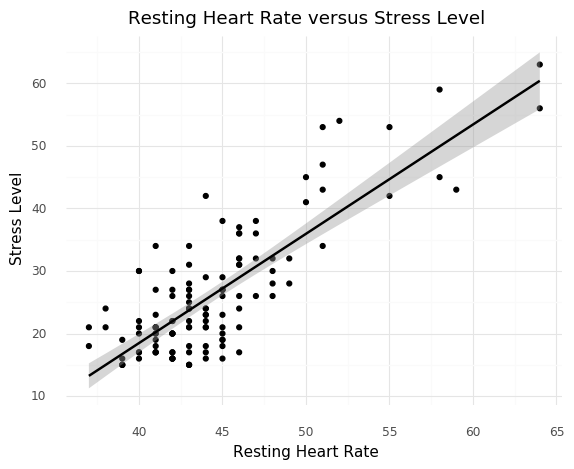

<ggplot: (8782358957773)>

In [57]:
df_combined = exercise_per_day(health, activities)
df_combined = df_combined.loc[df_combined["Sleep Hours"] != 0]
df_combined = df_combined.loc[df_combined["Stress Level"] > 14]
(ggplot(df_combined, aes(x = "Resting Heart Rate", y = "Stress Level")) 
 + geom_point()
 + theme_minimal()
 + stat_smooth(method = "lm")
 + labs(title = "Resting Heart Rate versus Stress Level"))

From the graph above, we can see that resting heart rate and stress level are positive linearly related. As resting heart rate goes up, stress level also goes up. 

Now below I will make a residual graph of the linear regression model:

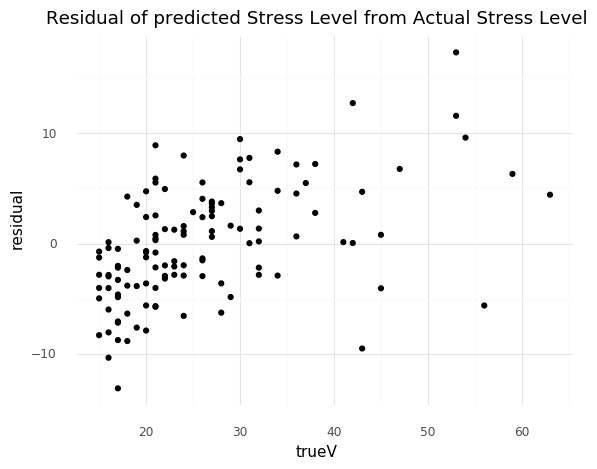

<ggplot: (8782351848753)>

In [58]:
true_vs_pred = pd.DataFrame({"predict": y_pred,"trueV": y})
true_vs_pred["residual"] = true_vs_pred["trueV"] - true_vs_pred["predict"]
(ggplot(true_vs_pred, aes(x = "trueV", y = "residual")) + 
 geom_point() + 
 theme_minimal() +
 ggtitle("Residual of predicted Stress Level from Actual Stress Level"))

From the graph above, we can see that the model over predicted for the low stress levels while gradually over predicting when the stress level gets higher. Although there is not that many datapoints, the residual does not look homoskedastic because the residuals get big at high and low stress levels.

## Question 2 Conclusion
You can accurately predict stress level from the other variables in the dataset. The linear regression model got an r2 score of .74 which is fairly high. Resting heart rate has the highest effect on stress level, as resting heart rate increases by 1 unit (1 standard deviation), stress level also increases by a large 6.33 levels. The best way to reduce stress is to sleep more, take more steps throughout the day, and also exercise. 

# Question 3: How can the activities be clustered and what are the characteristics of each cluster?
For this question, I will look at clustering my activities. Using features: "Time", "Calories", "Avg HR", "Max HR", I will group my data points. There were several datapoints where I forgot to end the activity on my watch, so I will remove these points. I created a dendrogram to visualize how many clusters are in the dataset

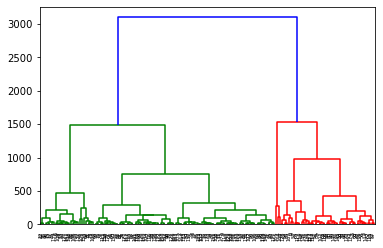

In [59]:
activities = activities.loc[activities["Time"] < 200]
features = ["Time", "Calories", "Avg HR", "Max HR"]
dendro = sch.dendrogram(sch.linkage(activities[features], method='ward'))

There are two groups in the dataset, so I will use agglomerative clustering with 2 clusters. I will use euclidean distance along with ward linkage. I am using ward linkage because it gives the best results.

In [60]:
hac = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
hac.fit(activities[features])

AgglomerativeClustering()

In [61]:
membership = hac.labels_
print("The silhouette score:",silhouette_score(activities[features], membership))

The silhouette score: 0.5395668774105017


The model performed somewhat well, it did an ok job at keeping clusters cohesive and seperable. I used silhouette score to measure this because it measures how cohesive and seperable a models clusters are. The silhouette score ranges from -1 to 1, where 1 is the best score. I got a score of about .54. 

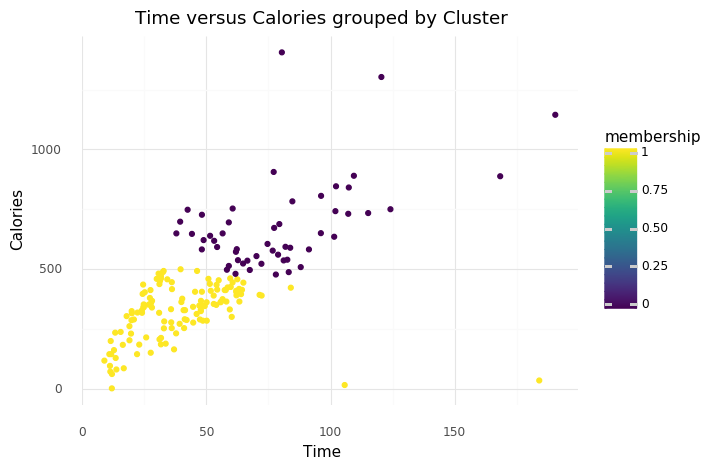

<ggplot: (8782359110305)>

In [62]:
(ggplot(activities, aes(x = "Time", y = "Calories", color = "membership")) 
 + geom_point()
 + theme_minimal()
 + labs(title = "Time versus Calories grouped by Cluster"))

The graph above shows that cluster 1 consists of the activities where I did not burn that many calories. Cluster 0 consists of the activities where I burned a significantly large number of calories. Cluster 0 represents hard workouts where I spent a long time exercising and burned lots of calories. These are workouts where I really pushed myself and worked hard.

## Question 3 Conclusion
The activities were grouped into two clusters. The first cluster represented activities where I did not burn that many calories. These are probably workouts where I did not have high intensity and did quickly. The second cluster represented activities where I burned lots of calories and spent a long time working out; these are workouts where I really pushed my self.

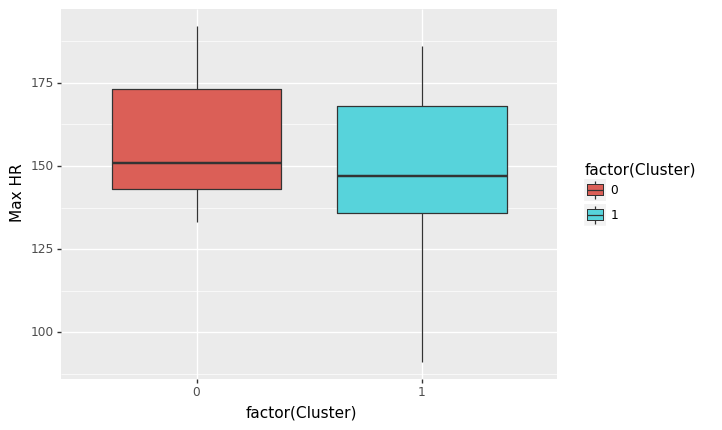

<ggplot: (8782359108289)>

In [63]:
activities["Cluster"] = membership
(ggplot(activities, aes( x = "factor(Cluster)", y = "Max HR")) + geom_boxplot(aes(fill = "factor(Cluster)")))